In [1]:
import matplotlib.pyplot as plt
import numpy as np

from lowEBMs.Packages.Configuration import importer, add_sellersparameters, parameterinterpolatorstepwise
from lowEBMs.Packages.Variables import variable_importer, Vars
from lowEBMs.Packages.RK4 import rk4alg
from lowEBMs.Packages.ModelEquation import model_equation
from lowEBMs.Packages.Optimization import coremodule

import lowEBMs.Packages.Constants as const
from lowEBMs import update_plotstyle, moving_average
import builtins
import matplotlib
update_plotstyle()
matplotlib.rcParams['lines.linewidth']=1.1

In [5]:
Year_volc, CWL_GMT,  EVA_GMT, CWLcorr_GMT=np.genfromtxt('Data/Volc_800_2000.txt',skip_header=1,unpack=True)

Lat_10,ZMT_10=np.loadtxt('Data/ERA_ZMT_Mean_10deginterpolated.txt')

Year_NorESM, SO4_FORC, SAT_GISS, SAT_VOLC, SAT_ZERO, SAT_AFIT, SAT_TREN= \
np.genfromtxt('Data/NorESM_Pinatubo_GMST_response.txt',skip_header=1,unpack=True)

NORESM_1990_2005=SAT_VOLC-SAT_TREN

In [12]:
labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
P0=np.array([70*4.2e6,210,2.5,1.165,1.165,1.165])
Pmin=np.array([1*4.2e6,190,1.9,0.9,0.9,0.9])
Pmax=np.array([100*4.2e6,240,3.3,1.3,1.3,1.3])
P_pert_ratio=1/10000

precision=1e-5
maxlength=int(100)
targetmode='Coupled'
target={'GMT':NORESM_1990_2005,'ZMT':ZMT_10}
targetfunction='LeastSquare'
ratio_ZMT_GMT=0.1
num_params=6
gamma0=1e-8
setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': int(num_params*2+1)}
control=True

config_CTRL=importer('Dev_Data/Optimization/Volcanic_Budyko_CTRL.ini')
variable_importer(config_CTRL,initialZMT=True,parallel=False)
config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
        
config_base=importer('Dev_Data/Optimization/Volcanic_Budyko.ini')
variable_importer(config_base,initialZMT=True,parallel=True,parallel_config=setup)

config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)

elevation=-0.0065*np.array(ParasCTRL[1][1])
Zero_ZMT,Zero_GMT=Vars.T,Vars.T_global
grid=Vars.Lat

F, dF, P, Ptrans , gamma, data=coremodule(config_base,P0,P_pert_ratio,Pmin,Pmax,labels,Zero_ZMT,Zero_GMT,grid,maxlength\
        ,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_params,gamma0,control,config_CTRL)

Loading Configuration from: Dev_Data/Optimization/Volcanic_Budyko_CTRL.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini
Loading Configuration from: Dev_Data/Optimization/Volcanic_Budyko.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Iteration no.0
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


KeyboardInterrupt: 

In [4]:
time_HADCM3_str=np.genfromtxt('Data/gmt_hadcm3.csv',usecols=[0],delimiter=',',skip_header=1,dtype='str',unpack=True,encoding='ISO-8859-1')
time_HADCM3=np.zeros(len(time_HADCM3_str))
for i in range(len(time_HADCM3_str)):
    if time_HADCM3_str[i][-4]=='.':
        year=float(time_HADCM3_str[i][-3:])
    if time_HADCM3_str[i][-5]=='.':
        year=float(time_HADCM3_str[i][-4:])
    if time_HADCM3_str[i][4]=='.':
        month=(float(time_HADCM3_str[i][3:5])-1)/12
    if time_HADCM3_str[i][5]=='.':
        month=(float(time_HADCM3_str[i][3:5])-1)/12
    day=float(time_HADCM3_str[i][:2])/365
    time_HADCM3[i]=year+month+day
GMT_HADCM3=np.genfromtxt('Data/gmt_hadcm3.csv',usecols=[17],delimiter=',',skip_header=1,unpack=True,encoding='ISO-8859-1')
order=np.argsort(time_HADCM3)
GMT_HADCM3_smoothed=moving_average(GMT_HADCM3[order],12)
Time_HADCM3_smoothed=moving_average(time_HADCM3[order],12)

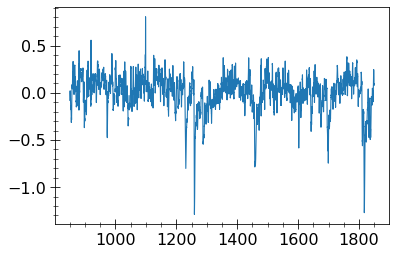

In [6]:
#plt.plot(Time_HADCM3_smoothed,GMT_HADCM3_smoothed)
#print(np.mean(GMT_HADCM3_smoothed))
#print(time_HADCM3[order][24-7])

start=0
end=0
for k in range(len(Time_HADCM3_smoothed)):
    if np.isnan(Time_HADCM3_smoothed[k]):
        start+=1
    else: break
for k in range(1,len(Time_HADCM3_smoothed)-1):
    if np.isnan(Time_HADCM3_smoothed[-k]):
        end+=1
    else: break
Time_int=np.array(Time_HADCM3_smoothed[start:-(end+1)], dtype=int)
Time_HADCM3_smoothed_corrected=Time_HADCM3_smoothed[start:-(end+1)]
GMT_HADCM3_smoothed_corrected=GMT_HADCM3_smoothed[start:-(end+1)]
k800=np.where(Time_int==800)[0]
k850=np.where(Time_int==850)[0]
k1850=np.where(Time_int==1850)[0]
Time_850_1850=Time_HADCM3_smoothed_corrected[k850[0]-1:k1850[0]-1]
GMT_850_1850=GMT_HADCM3_smoothed_corrected[k850[0]-1:k1850[0]-1]
GMT_850_1850_response=np.array(GMT_850_1850)-np.nanmean(GMT_850_1850)
plt.plot(Time_850_1850,GMT_850_1850_response)

In [5]:
print(len(Time_850_1850))

12000


In [56]:
labels=[['eqparam','c_ao'],['func3','a'],['func3','b'],['func4','factor_oc'],['func4','factor_kwv'],['func4','factor_kair']]
P0=np.array([70*4.2e6,210,2.5,1.165,1.165,1.165])
Pmin=np.array([1*4.2e6,190,1.9,0.9,0.9,0.9])
Pmax=np.array([100*4.2e6,240,3.3,1.3,1.3,1.3])
P_pert_ratio=1/10000

precision=1e-5
maxlength=int(5)
targetmode='Coupled'
target={'GMT':GMT_850_1850_response-0.1,'ZMT':ZMT_10}
targetfunction='LeastSquare'
ratio_ZMT_GMT=0.2
num_params=6
gamma0=1e-8
setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': int(num_params*2+1)}
control=True

config_CTRL=importer('Dev_Data/Optimization/Budyko_HadCM3_CTRL.ini')
variable_importer(config_CTRL,initialZMT=True,parallel=False)
config_CTRL,ParasCTRL=add_sellersparameters(config_CTRL,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',4,2,True,True)
        
config_base=importer('Dev_Data/Optimization/Budyko_HadCM3.ini')
variable_importer(config_base,initialZMT=True,parallel=True,parallel_config=setup)

config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',4,2,True,True)

elevation=-0.0065*np.array(ParasCTRL[1][1])
Zero_ZMT,Zero_GMT=Vars.T,Vars.T_global
grid=Vars.Lat

F, dF, P, Ptrans , gamma, data=coremodule(config_base,P0,P_pert_ratio,Pmin,Pmax,labels,Zero_ZMT,Zero_GMT,grid,maxlength\
        ,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_params,gamma0,control,config_CTRL,monthly=True)

Loading Configuration from: Dev_Data/Optimization/Budyko_HadCM3_CTRL.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini
Loading Configuration from: Dev_Data/Optimization/Budyko_HadCM3.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Iteration no.0
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


/Home/siv32/bsc029/.local/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


Transit State reached after 100000 steps within 511.3102135658264 seconds



[1214.84066446 1214.80104294 1214.88029905 1215.59239813 1214.08938153
 1214.63393307 1215.04754622 1214.83811972 1214.84320924 1214.84045702
 1214.8408719  1214.83147043 1214.84985928]
1e-08
[2.94002364e+08 2.09990606e+02 2.50006756e+00 1.16500015e+00
 1.16500001e+00 1.16500056e+00]
Iteration no.1
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


Transit State reached after 100000 steps within 511.5661826133728 seconds



[1213.32749167 1213.28788019 1213.36711621 1214.07831984 1212.57711414
 1213.12106207 1213.5340715  1213.32495025 1213.33003313 1213.32728454
 1213.32769879 1213.31830987 1213.33667425]
8.173006438057674e-06
[2.95934088e+08 2.02322254e+02 2.55520119e+00 1.16512556e+00
 1.16501023e+00 1.16545366e+00]
Iteration no.2
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


Transit State reached after 100000 steps within 517.3185024261475 seconds



[309.72558129 309.71568211 309.73551704 310.06992708 309.38535956
 309.77943537 309.67184618 309.72386771 309.72739042 309.7252936
 309.72590344 309.71697991 309.7341631 ]
1.2788979541015956e-05
[2.96690759e+08 1.96850429e+02 2.53272724e+00 1.16526157e+00
 1.16503378e+00 1.16611708e+00]
Iteration no.3
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


Transit State reached after 100000 steps within 505.44794940948486 seconds



[160.0280254  160.0239726  160.03208238 160.07532854 159.98080579
 160.03768155 160.0183825  160.02806796 160.02798286 160.02804439
 160.02800642 160.02840125 160.0276498 ]
1.4851981592367788e-05
[2.97050040e+08 1.95973022e+02 2.52804564e+00 1.16525775e+00
 1.16503208e+00 1.16608338e+00]
Iteration no.4
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.


Transit State reached after 100000 steps within 505.65917205810547 seconds


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


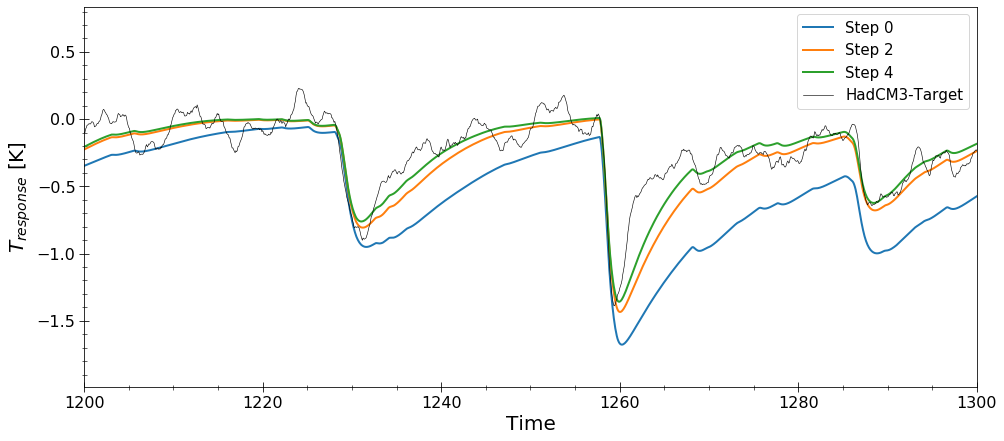

In [61]:
fig,ax=plt.subplots(figsize=(16,7))
for k in [0,2,4]:
    plt.plot(Time_850_1850,data[1][k,0],label='Step '+str(k),linewidth=2)
plt.plot(Time_850_1850,GMT_850_1850_response-0.1,c='k',linewidth=0.6,label='HadCM3-Target')
plt.legend(fontsize=15)
plt.xlim(1200,1300)
#plt.xlim(850,1850)
ax.set_xlabel('Time'),ax.set_ylabel('$T_{response}$ [K]')
plt.savefig('Plots/HadCM3_optimization_full_GMT_Samalas_5steps.eps',format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


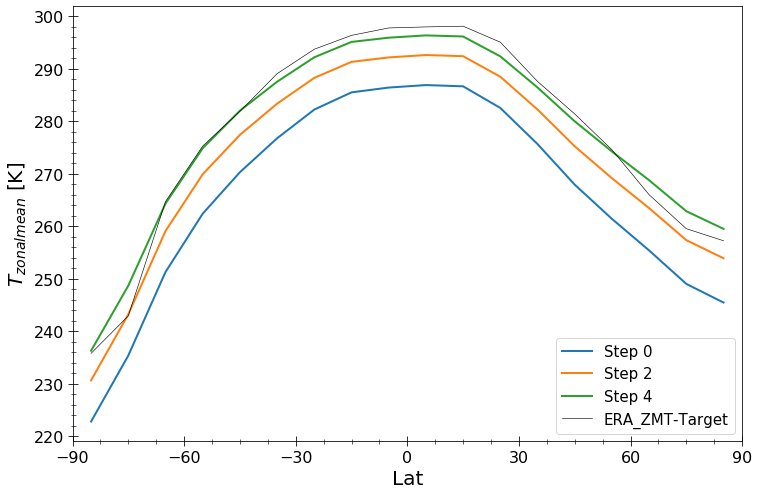

In [62]:
fig,ax=plt.subplots(figsize=(12,8))
for k in [0,2,4]:
    plt.plot(Vars.Lat,data[0][k,0],label='Step '+str(k),linewidth=2)
plt.plot(Lat_10,ZMT_10,c='k',linewidth=0.6,label='ERA_ZMT-Target')
plt.legend(fontsize=15)
ax.set_xticks(np.linspace(-90,90,7)), ax.set_xlim(-90,90)
ax.set_xlabel('Lat'),ax.set_ylabel('$T_{zonal mean}$ [K]')
plt.savefig('Data/HadCM3_optimization_full_ZMT.eps',format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


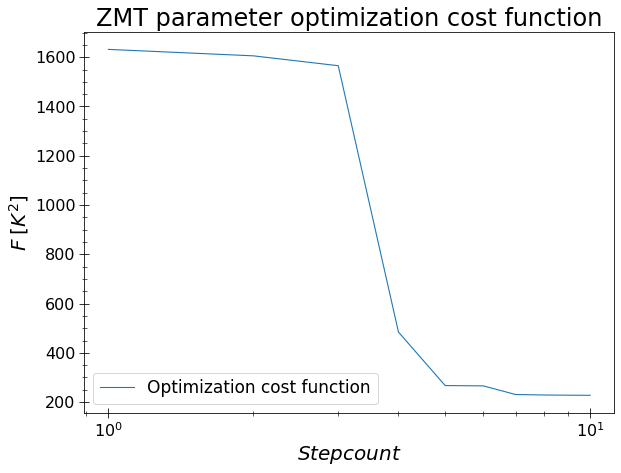

In [49]:
plt.figure(figsize=(9.5,7))
plt.plot(np.arange(10)+1,F[:,0],label='Optimization cost function')
#plt.yscale('log')
plt.xscale('log')
plt.xlabel('$Stepcount$'),plt.ylabel('$F\; [K^2]$')
#plt.figlegend((line2),['ERA-Target ZMT'],fontsize=17,bbox_to_anchor=(0.858,0.215))
plt.legend(fontsize=17)
plt.title('ZMT parameter optimization cost function')
#plt.xlim(1808,1858)
plt.savefig('Data/HadCM3_Optimization_F.eps',format='EPS',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


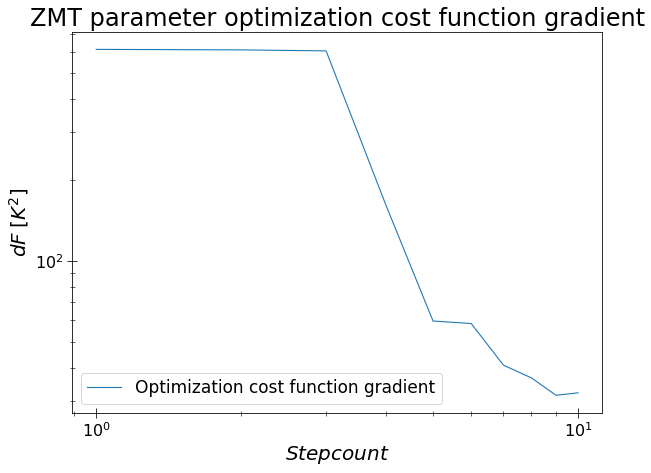

In [55]:
plt.figure(figsize=(9.5,7))
plt.plot(np.arange(10)+1,np.abs(dF[:,0]),label='Optimization cost function gradient')
plt.yscale('log')
plt.xscale('log')
#plt.ylim(-1.5e5,1e5)
plt.xlabel('$Stepcount$'),plt.ylabel('$dF\; [K^2]$')
#plt.figlegend((line2),['ERA-Target ZMT'],fontsize=17,bbox_to_anchor=(0.858,0.215))
plt.legend(fontsize=17,loc='lower left')
plt.title('ZMT parameter optimization cost function gradient')
#plt.xlim(1808,1858)
plt.savefig('Data/HadCM3_Optimization_dF_log.eps',format='EPS',bbox_inches='tight')

In [136]:
j=0
time=[]
t=850*365*24*60*60
for i in range(0,365*1000):
    month=int((i%365)/365*12)
    day=int(i%(365/12))
    #print(month)
    t+=24*60*60
    if day==15:
        time.append(t)
        j+=1
print(np.array(time)[:120]/(365*24*60*60))
#np.arange(850*365,1850*365,30)

[850.04383562 850.12876712 850.2109589  850.29589041 850.37808219
 850.4630137  850.54520548 850.62739726 850.71232877 850.79452055
 850.87945205 850.96164384 851.04657534 851.12876712 851.2109589
 851.29589041 851.37808219 851.4630137  851.54520548 851.62739726
 851.71232877 851.79452055 851.87945205 851.96164384 852.04657534
 852.12876712 852.2109589  852.29589041 852.37808219 852.4630137
 852.54520548 852.62739726 852.71232877 852.79452055 852.87945205
 852.96164384 853.04657534 853.12876712 853.2109589  853.29589041
 853.37808219 853.4630137  853.54520548 853.62739726 853.71232877
 853.79452055 853.87945205 853.96164384 854.04657534 854.12876712
 854.2109589  854.29589041 854.37808219 854.4630137  854.54520548
 854.62739726 854.71232877 854.79452055 854.87945205 854.96164384
 855.04657534 855.12876712 855.2109589  855.29589041 855.37808219
 855.4630137  855.54520548 855.62739726 855.71232877 855.79452055
 855.87945205 855.96164384 856.04657534 856.12876712 856.2109589
 856.29589041

In [23]:
config_CTRL2=importer('Dev_Data/Optimization/Budyko_HadCM3_CTRL.ini')
variable_importer(config_CTRL2,control=True)
config_CTRL2,ParasCTRL=add_sellersparameters(config_CTRL2,\
                                        parameterinterpolatorstepwise,'SellersParameterization.ini',4,2,True,True)

#add_parameters
Time_Spinup2,ZMT_Spinup2,GMT_Spinup2=rk4alg(model_equation,config_CTRL2['eqparam'],config_CTRL2['rk4input'],config_CTRL2['funccomp'],daily=True)

Loading Configuration from: Dev_Data/Optimization/Budyko_HadCM3_CTRL.ini
Starting controlrun with a temperature accuracy of 0.001 K on the GMT over 1000 datapoints.
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


/Home/siv32/bsc029/.local/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


Eq. State reached after 63062 steps, within 78.05740189552307 seconds


In [2]:
config_base2=importer('Dev_Data/Optimization/Budyko_HadCM3.ini')
variable_importer(config_base2)

config_base2,ParasCTRL=add_sellersparameters(config_base2,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',4,2,True,True)

#Vars.T,Vars.T_global=ZMT_Spinup2[-1],GMT_Spinup2[-1]
Time_full,ZMT_full,GMT_full=rk4alg(model_equation,config_base2['eqparam'],config_base2['rk4input'],config_base2['funccomp'],monthly=True)

Loading Configuration from: Dev_Data/Optimization/Budyko_HadCM3.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


In [3]:
print(Time_full)

[2.68056000e+10 2.68068960e+10 2.68095744e+10 2.68121664e+10
 2.68148448e+10 2.68174368e+10 2.68201152e+10 2.68227072e+10
 2.68252992e+10 2.68279776e+10 2.68305696e+10 2.68332480e+10
 2.68358400e+10 2.68385184e+10 2.68411104e+10 2.68437024e+10
 2.68463808e+10 2.68489728e+10 2.68516512e+10 2.68542432e+10
 2.68568352e+10 2.68595136e+10 2.68621056e+10 2.68647840e+10
 2.68673760e+10 2.68700544e+10 2.68726464e+10 2.68752384e+10
 2.68779168e+10 2.68805088e+10 2.68831872e+10 2.68857792e+10
 2.68883712e+10 2.68910496e+10 2.68936416e+10 2.68963200e+10
 2.68989120e+10 2.69015904e+10 2.69041824e+10 2.69067744e+10
 2.69094528e+10 2.69120448e+10 2.69147232e+10 2.69173152e+10
 2.69199072e+10 2.69225856e+10 2.69251776e+10 2.69278560e+10
 2.69304480e+10 2.69331264e+10 2.69357184e+10 2.69383104e+10
 2.69409888e+10 2.69435808e+10 2.69462592e+10 2.69488512e+10
 2.69514432e+10 2.69541216e+10 2.69567136e+10 2.69593920e+10
 2.69619840e+10 2.69646624e+10 2.69672544e+10 2.69698464e+10
 2.69725248e+10 2.697511

1849.958904109589
1849.916095890411


(1800, 1850)

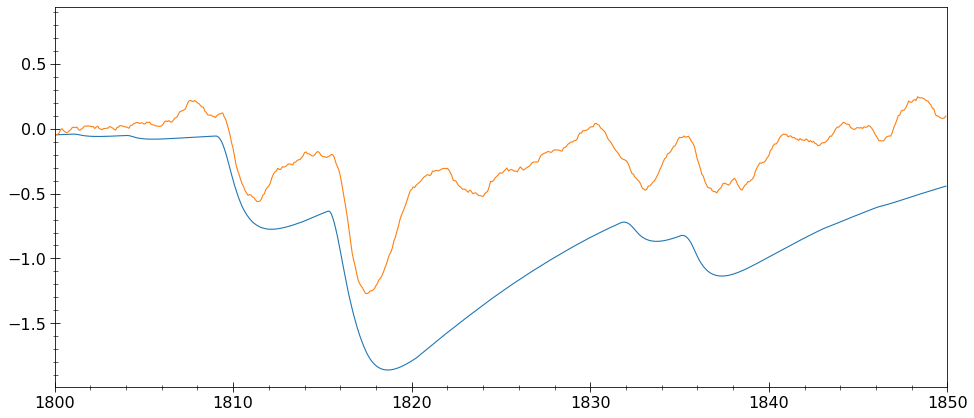

In [28]:
fig,ax=plt.subplots(figsize=(16,7))
print(Time_full[-1]/const.time_sec_year)
print(Time_850_1850[-1])
plt.plot(Time_850_1850,GMT_full[:-1]-GMT_full[0])
plt.plot(Time_850_1850,GMT_850_1850_response)
plt.xlim(1800,1850)

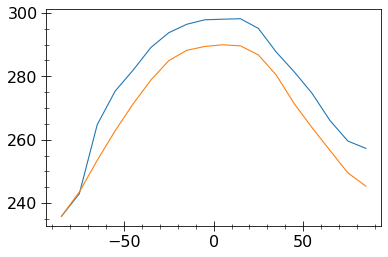

In [26]:
plt.plot(Lat_10,ZMT_10)
#plt.plot(Vars.Lat,ZMT_Spinup2[-1])

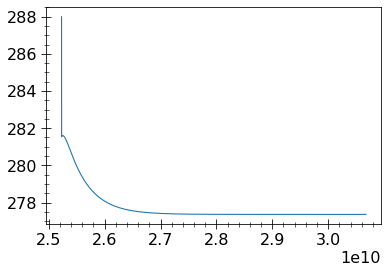

In [24]:
plt.plot(Time_Spinup2,GMT_Spinup2)